In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
animal = pd.read_csv("../data/animal_smiles_r_v3.csv")
animal = animal[animal["smiles_r"]!="Cannot_do"].reset_index(drop=True)

rat = animal[["InChICode_standardised",  "smiles_r", "rat_VDss_L_kg", "rat_CL_mL_min_kg", "rat_fup"]].dropna(subset=["rat_VDss_L_kg", "rat_CL_mL_min_kg", "rat_fup"], how="all").reset_index(drop=True)


In [4]:
rat

,InChICode_standardised,smiles_r,rat_VDss_L_kg,rat_CL_mL_min_kg,rat_fup
0,"InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...",O=c1[n-]cc(F)c(=O)[n-]1,0.25,33.0,0.690
1,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,16.70,65.0,NaN
2,InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...,5.00,150.0,NaN
3,InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...,Nc1nc([NH2+]C2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)...,NaN,30.0,NaN
4,InChI=1S/C15H23N3O2/c1-4-18(5-2)11-10-16-15(20...,CC[NH+](CC)CCNC(=O)c1ccc(NC(C)=O)cc1,2.90,28.0,0.580
...,...,...,...,...,...
319,InChI=1S/C17H15N5O/c1-3-21(12(2)23)15-6-4-5-13...,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,1.72,20.7,NaN
320,InChI=1S/C12H20N4O7/c1-4(18)15-8-5(16-12(13)14...,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,0.80,31.7,NaN
321,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,0.86,25.1,0.687
322,InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...,C[NH+](C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12,3.53,29.4,NaN


In [5]:
inchi = rat[["InChICode_standardised", "smiles_r"]]
for endpoint in ["rat_VDss_L_kg","rat_CL_mL_min_kg"]:
    print("Transformed endpoint to log base 10")
    rat[endpoint] = np.log10(rat[endpoint])
rat

Transformed endpoint to log base 10
Transformed endpoint to log base 10


,InChICode_standardised,smiles_r,rat_VDss_L_kg,rat_CL_mL_min_kg,rat_fup
0,"InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...",O=c1[n-]cc(F)c(=O)[n-]1,-0.602060,1.518514,0.690
1,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,1.222716,1.812913,NaN
2,InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...,0.698970,2.176091,NaN
3,InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...,Nc1nc([NH2+]C2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)...,NaN,1.477121,NaN
4,InChI=1S/C15H23N3O2/c1-4-18(5-2)11-10-16-15(20...,CC[NH+](CC)CCNC(=O)c1ccc(NC(C)=O)cc1,0.462398,1.447158,0.580
...,...,...,...,...,...
319,InChI=1S/C17H15N5O/c1-3-21(12(2)23)15-6-4-5-13...,CCN(C(C)=O)c1cccc(-c2ccnc3c(C#N)cnn23)c1,0.235528,1.315970,NaN
320,InChI=1S/C12H20N4O7/c1-4(18)15-8-5(16-12(13)14...,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,-0.096910,1.501059,NaN
321,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,-0.065502,1.399674,0.687
322,InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...,C[NH+](C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12,0.547775,1.468347,NaN


In [6]:
rat = rat.groupby('smiles_r').median().reset_index()
rat

,smiles_r,rat_VDss_L_kg,rat_CL_mL_min_kg,rat_fup
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,0.897627,1.616476,NaN
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1,NaN,NaN,0.3100
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CCC4[C@H]...,-0.130768,0.113943,NaN
3,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,0.755875,1.740363,0.0088
4,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.113943,0.892095,0.1500
...,...,...,...,...
319,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...,0.908485,1.653213,0.6800
320,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...,0.681241,1.959995,0.3400
321,[O-]c1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H...,1.041393,2.044148,NaN
322,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,1.100371,1.821514,0.3700


In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "rat_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "rat_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "rat_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "rat_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
smiles_r = rat[["smiles_r"]]
smiles_r

,smiles_r
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CCC4[C@H]...
3,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
4,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1
...,...
319,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
320,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...
321,[O-]c1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H...
322,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1


In [9]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = rat['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


100%|████████████████████████████████████████| 324/324 [00:02<00:00, 116.80it/s]


In [10]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = rat['smiles_r']

In [11]:
Mordred_table = Mordred_table.dropna(axis='columns')
selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Mordred_table = Mordred_table [selected_Features]
# Get correlation matrix and lower triangle of pairwise correlations in long format
data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
# Get absolute sum of correlation across features
# The lower the index, the less correlation to the full data frame
# We want to drop features with highest correlation, so drop higher index
variable_cor_sum = data_cor_df.abs().sum().sort_values().index
# And subset to only variable combinations that pass the threshold
pairwise_df = pairwise_df.query("correlation > 0.95")
excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
excluded_features = list(set(excluded.tolist()))
print(len(excluded_features))
new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)
max_feature_values = new_Mordred_table.max().abs()
min_feature_values = new_Mordred_table.min().abs()
#outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
#print(len(outlier_features))
#new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
new_Mordred_table['smiles_r'] = rat['smiles_r']
new_Mordred_table

797
411


/tmp/ipykernel_1345971/3888230042.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)


,nAcid,nBase,SpDiam_A,VE1_A,VR2_A,VR3_A,nSpiro,nBridgehead,nHetero,nH,...,GGI7,GGI8,Diameter,MWC10,SRW03,SRW09,TSRW10,AMW,mZagreb1,smiles_r
0,1.0,0.0,4.952581,3.888933,14.362248,6.544103,0.0,0.0,2.0,27.0,...,0.262153,0.205593,10.0,11.807615,0.0,0.000000,56.111877,6.106156,11.180556,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,0.0,1.0,4.453621,3.435097,4.491949,4.477816,0.0,0.0,1.0,18.0,...,0.071181,0.032754,9.0,10.478217,0.0,0.000000,44.372474,5.879480,5.333333,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,0.0,0.0,5.188102,4.100787,8.224812,6.075559,0.0,0.0,2.0,28.0,...,0.364619,0.197027,11.0,12.547770,0.0,7.247793,73.338433,6.121744,7.541667,C#C[C@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CCC4[C@H]...
3,1.0,0.0,5.164227,4.066097,7.841830,5.938972,0.0,0.0,2.0,23.0,...,0.336841,0.184681,11.0,12.482571,0.0,7.234898,72.152610,6.559341,7.291667,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
4,0.0,3.0,4.865076,4.074398,6.443704,5.649563,0.0,0.0,5.0,16.0,...,0.177083,0.053162,9.0,11.818902,0.0,5.379897,63.023277,8.137759,6.527778,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.0,2.0,4.851495,3.906670,24.521313,7.561367,0.0,0.0,12.0,17.0,...,0.473958,0.296564,15.0,12.096152,0.0,6.861711,77.585634,9.091836,11.423611,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
320,1.0,1.0,5.339943,4.119583,10.440525,6.399217,0.0,2.0,3.0,29.0,...,0.263889,0.073066,11.0,12.678595,0.0,0.000000,60.334421,6.173959,6.291667,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...
321,1.0,1.0,5.430820,4.286552,12.645322,6.750895,1.0,2.0,5.0,27.0,...,0.291667,0.156478,11.0,13.051995,0.0,7.321850,77.785047,6.739510,7.125000,[O-]c1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H...
322,0.0,1.0,4.956344,3.727444,6.199683,5.302657,0.0,0.0,1.0,26.0,...,0.048611,0.000000,8.0,11.710045,0.0,0.000000,51.418286,5.550136,4.034722,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1


In [12]:
Ser_Mol = rat['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = rat['smiles_r']

In [13]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]
new_Morganfingerprint_table['smiles_r'] = rat['smiles_r']
new_Morganfingerprint_table

153


/tmp/ipykernel_1345971/3603026286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Morganfingerprint_table['smiles_r'] = rat['smiles_r']


,Mfp1,Mfp13,Mfp80,Mfp90,Mfp114,Mfp116,Mfp117,Mfp118,Mfp140,Mfp147,...,Mfp1917,Mfp1921,Mfp1928,Mfp1955,Mfp1970,Mfp1980,Mfp1991,Mfp2031,Mfp2038,smiles_r
0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CCC4[C@H]...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1,0,1,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
320,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...
321,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,[O-]c1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H...
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1


In [14]:
Mordred_columns = new_Mordred_table.columns[:-1].tolist()
mfp_columns = new_Morganfingerprint_table.columns[:-1].tolist()
#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mfp_mordred_columns = Mordred_columns + mfp_columns
print(len(features_mfp_mordred_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_columns_rat_model.txt", "w")
for item in features_mfp_mordred_columns:
   f.write(item + "\n")
f.close()

539


In [15]:
#read from file
file = open("features_mfp_mordred_columns_rat_model.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]
features_mfp_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR2_A',
 'VR3_A',
 'nSpiro',
 'nBridgehead',
 'nHetero',
 'nH',
 'nC',
 'nN',
 'nO',
 'nS',
 'nX',
 'ATS3dv',
 'ATS8dv',
 'ATS1s',
 'ATS2s',
 'ATS3s',
 'ATS4s',
 'ATS5s',
 'ATS6s',
 'ATS7s',
 'ATS8s',
 'ATS1m',
 'ATS4m',
 'ATS8m',
 'ATS0p',
 'ATS6i',
 'ATS8i',
 'AATS1dv',
 'AATS3dv',
 'AATS4dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS4d',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS4s',
 'AATS1Z',
 'AATS0m',
 'AATS3m',
 'AATS4m',
 'AATS0v',
 'AATS3v',
 'AATS4v',
 'AATS4se',
 'AATS1are',
 'AATS3are',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'AATS4i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC0dv',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC

In [16]:
rat_mfp = pd.merge(rat, new_Morganfingerprint_table)
rat_mfp_Mordred = pd.merge(rat_mfp, new_Mordred_table)
rat_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

,smiles_r,rat_VDss_L_kg,rat_CL_mL_min_kg,rat_fup,Mfp1,Mfp13,Mfp80,Mfp90,Mfp114,Mfp116,...,GGI6,GGI7,GGI8,Diameter,MWC10,SRW03,SRW09,TSRW10,AMW,mZagreb1
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,0.897627,1.616476,NaN,0,0,1,0,1,0,...,0.346122,0.262153,0.205593,10.0,11.807615,0.0,0.000000,56.111877,6.106156,11.180556
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1,NaN,NaN,0.3100,1,0,1,0,0,0,...,0.122449,0.071181,0.032754,9.0,10.478217,0.0,0.000000,44.372474,5.879480,5.333333
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CC=C4CC(=O)CCC4[C@H]...,-0.130768,0.113943,NaN,0,0,1,0,0,0,...,0.621270,0.364619,0.197027,11.0,12.547770,0.0,7.247793,73.338433,6.121744,7.541667
3,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,0.755875,1.740363,0.0088,0,0,0,0,0,0,...,0.600862,0.336841,0.184681,11.0,12.482571,0.0,7.234898,72.152610,6.559341,7.291667
4,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.113943,0.892095,0.1500,0,0,0,0,0,0,...,0.508707,0.177083,0.053162,9.0,11.818902,0.0,5.379897,63.023277,8.137759,6.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...,0.908485,1.653213,0.6800,1,0,1,1,1,0,...,0.779683,0.473958,0.296564,15.0,12.096152,0.0,6.861711,77.585634,9.091836,11.423611
320,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...,0.681241,1.959995,0.3400,0,0,1,0,0,0,...,0.584490,0.263889,0.073066,11.0,12.678595,0.0,0.000000,60.334421,6.173959,6.291667
321,[O-]c1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H...,1.041393,2.044148,NaN,0,0,1,0,0,0,...,0.755193,0.291667,0.156478,11.0,13.051995,0.0,7.321850,77.785047,6.739510,7.125000
322,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,1.100371,1.821514,0.3700,0,0,0,0,0,0,...,0.235102,0.048611,0.000000,8.0,11.710045,0.0,0.000000,51.418286,5.550136,4.034722


rat_VDss_L_kg
0
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=42)
62
2-fold :  58.06451612903226
3-fold :  69.35483870967742
5-fold :  90.32258064516128
gmfe :  2.1231290521467443
mfe :  1.222044401927102
bias :  -0.04646430016653599
rmse  0.42950543367303173
r2  0.48134336839522773
saving model


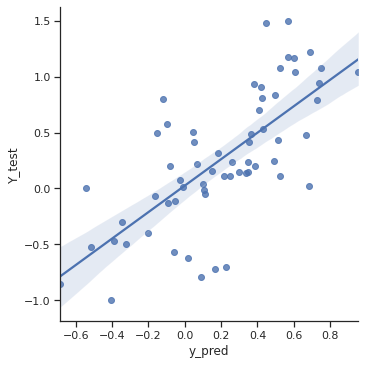

1
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
62
2-fold :  59.67741935483871
3-fold :  83.87096774193549
5-fold :  90.32258064516128
gmfe :  1.9800031160202878
mfe :  1.2370638728858783
bias :  0.0002932526609601138
rmse  0.4118464095943852
r2  0.5026086223657122
saving model


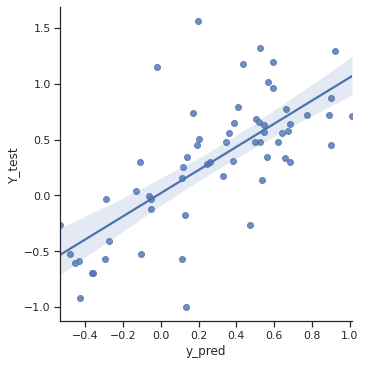

2
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
62
2-fold :  56.451612903225815
3-fold :  74.19354838709677
5-fold :  98.38709677419355
gmfe :  2.023366207927978
mfe :  1.3038142658639722
bias :  0.20766317692438496
rmse  0.3676707076172452
r2  0.5379392741703787


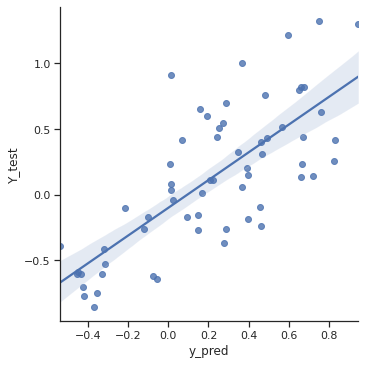

3
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
62
2-fold :  51.61290322580645
3-fold :  74.19354838709677
5-fold :  88.70967741935483
gmfe :  2.3056670438789886
mfe :  1.3123855728918024
bias :  0.012047735815358548
rmse  0.4890237834818009
r2  0.41061861129757127


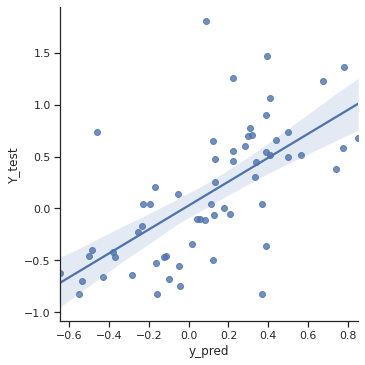

4
(248, 539)
(61, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
61
2-fold :  55.73770491803278
3-fold :  78.68852459016394
5-fold :  88.52459016393442
gmfe :  2.1733935239231643
mfe :  1.3208041292291346
bias :  -0.10864976024025386
rmse  0.4409986466470151
r2  0.49863816847435594


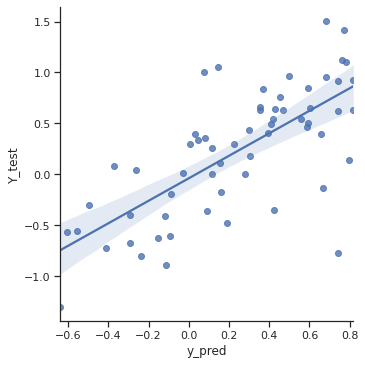

0
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
62
2-fold :  53.2258064516129
3-fold :  79.03225806451613
5-fold :  93.54838709677419
gmfe :  2.0487978675696765
mfe :  1.3181388672538046
bias :  0.009289589515491664
rmse  0.40381244081195633
r2  0.5094040341093906


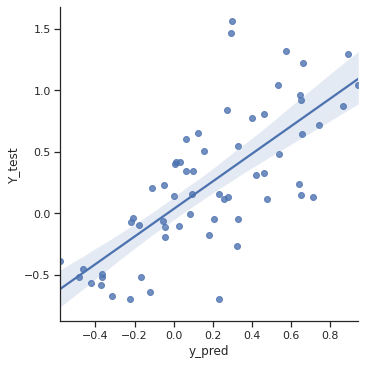

1
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
62
2-fold :  50.0
3-fold :  64.51612903225806
5-fold :  87.09677419354838
gmfe :  2.4334950138865588
mfe :  1.3417493393952034
bias :  -0.1802755752624745
rmse  0.479254248632449
r2  0.3794730341391245


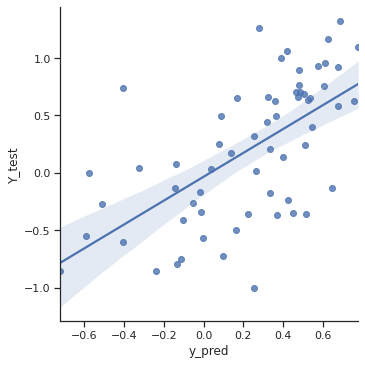

2
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=43)
62
2-fold :  61.29032258064516
3-fold :  75.80645161290323
5-fold :  87.09677419354838
gmfe :  2.1324480329898776
mfe :  1.2658607792640226
bias :  0.16354249333975068
rmse  0.44596841330879416
r2  0.4784301554871574


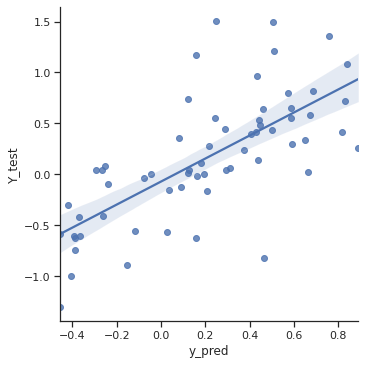

3
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
62
2-fold :  53.2258064516129
3-fold :  74.19354838709677
5-fold :  87.09677419354838
gmfe :  2.2287177025593063
mfe :  1.3255863985946998
bias :  0.01020689712276826
rmse  0.46400703544504845
r2  0.5160212478121902


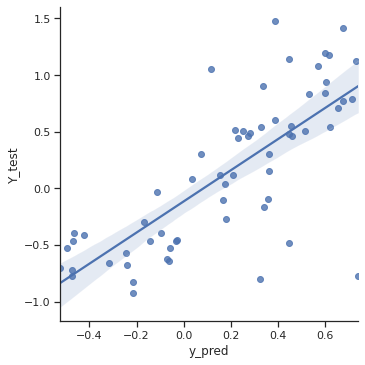

4
(248, 539)
(61, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=43)
61
2-fold :  63.934426229508205
3-fold :  81.9672131147541
5-fold :  93.44262295081968
gmfe :  1.9654235212345408
mfe :  1.2394063790592393
bias :  -0.04955586211399776
rmse  0.4113905848563456
r2  0.32125000431766004
saving model


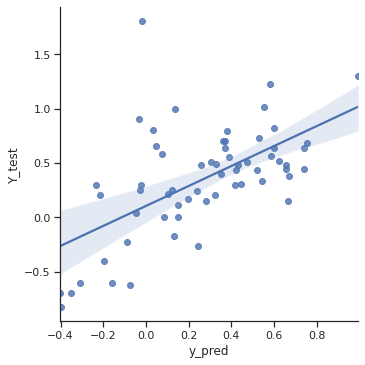

0
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=44)
62
2-fold :  51.61290322580645
3-fold :  74.19354838709677
5-fold :  91.93548387096774
gmfe :  2.160883341861085
mfe :  1.3237253351869822
bias :  0.007296098506344911
rmse  0.44583812347350266
r2  0.45502734235252895


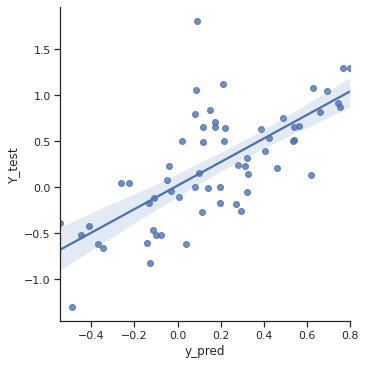

1
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=44)
62
2-fold :  50.0
3-fold :  70.96774193548387
5-fold :  87.09677419354838
gmfe :  2.3157148497784927
mfe :  1.3557843020898805
bias :  0.1348839052472311
rmse  0.4589361898964345
r2  0.4529890168013134


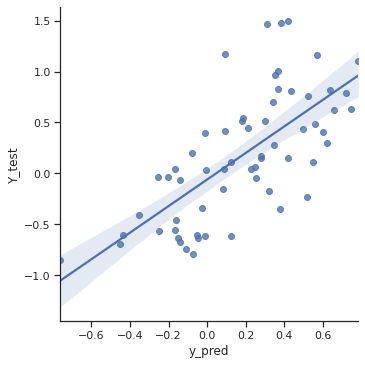

2
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=44)
62
2-fold :  56.451612903225815
3-fold :  75.80645161290323
5-fold :  91.93548387096774
gmfe :  2.093982826000153
mfe :  1.3087647395626338
bias :  -0.3123250129404189
rmse  0.4223765283109465
r2  0.43540156677814357


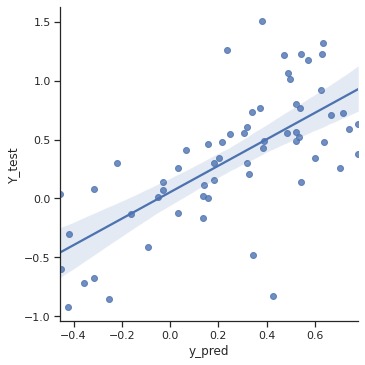

3
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
62
2-fold :  67.74193548387096
3-fold :  83.87096774193549
5-fold :  90.32258064516128
gmfe :  1.9749717484981195
mfe :  1.2227288360920374
bias :  0.09082555143395774
rmse  0.44838856772605123
r2  0.42255889084429654


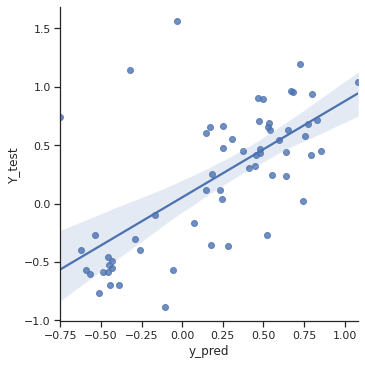

4
(248, 539)
(61, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
61
2-fold :  52.459016393442624
3-fold :  67.21311475409836
5-fold :  83.60655737704919
gmfe :  2.36027523271103
mfe :  1.3147266592277833
bias :  0.10716562239650065
rmse  0.495445404196485
r2  0.321359982656108


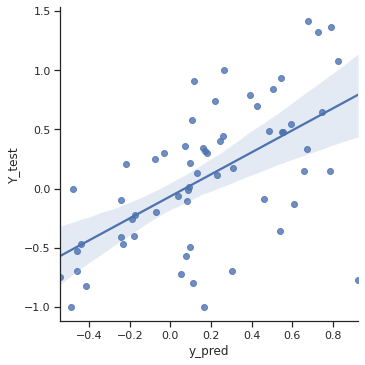

0
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
62
2-fold :  58.06451612903226
3-fold :  79.03225806451613
5-fold :  90.32258064516128
gmfe :  2.1547725699401417
mfe :  1.3102026135432876
bias :  -0.20372564208249888
rmse  0.4332832798688436
r2  0.47764468294682294


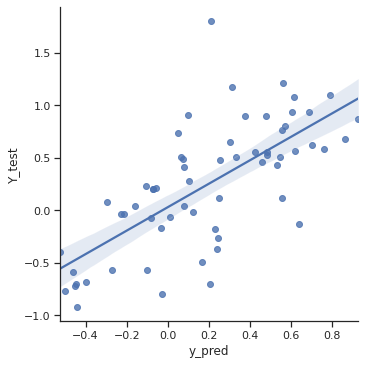

1
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=45)
62
2-fold :  66.12903225806451
3-fold :  79.03225806451613
5-fold :  85.48387096774194
gmfe :  2.019351059163084
mfe :  1.212449605313605
bias :  0.042100348556363354
rmse  0.4391343666495792
r2  0.3272838324843347


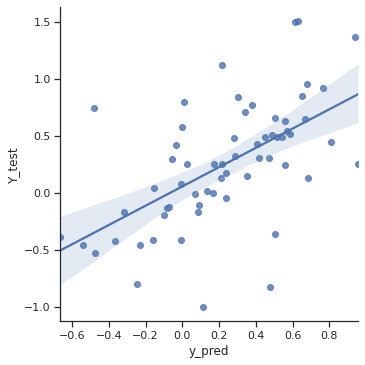

2
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
62
2-fold :  56.451612903225815
3-fold :  79.03225806451613
5-fold :  93.54838709677419
gmfe :  2.0851522137372474
mfe :  1.241168352264652
bias :  0.19559217005105517
rmse  0.42507222509051507
r2  0.4589240562697051


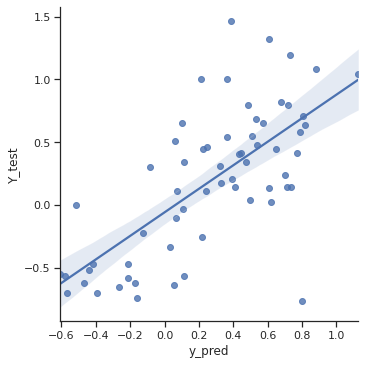

3
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=45)
62
2-fold :  56.451612903225815
3-fold :  75.80645161290323
5-fold :  93.54838709677419
gmfe :  2.126100781172359
mfe :  1.3272022660812426
bias :  0.07655145870162439
rmse  0.39776085733192673
r2  0.5473200772542779


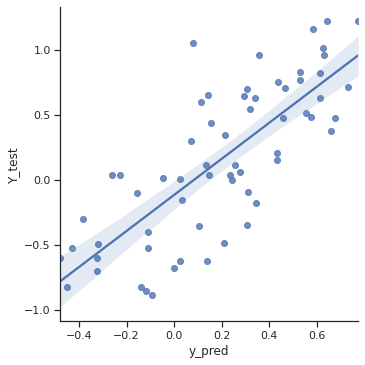

4
(248, 539)
(61, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=45)
61
2-fold :  50.81967213114754
3-fold :  67.21311475409836
5-fold :  86.88524590163934
gmfe :  2.2923817795160075
mfe :  1.3464198500148805
bias :  -0.06554733678583125
rmse  0.4738188037071696
r2  0.5250355364612604


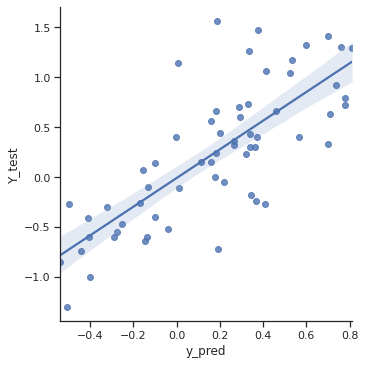

0
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)
62
2-fold :  54.83870967741935
3-fold :  67.74193548387096
5-fold :  87.09677419354838
gmfe :  2.2710719823425256
mfe :  1.314207666803923
bias :  0.2648208089509304
rmse  0.4522756539533059
r2  0.43025985930177313


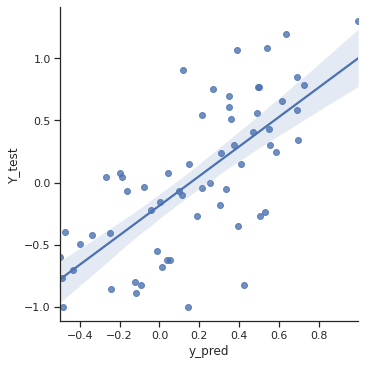

1
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
62
2-fold :  48.38709677419355
3-fold :  70.96774193548387
5-fold :  91.93548387096774
gmfe :  2.13893575190633
mfe :  1.3786643503203861
bias :  -0.4462627748507192
rmse  0.41375531998483617
r2  0.4766594245362691


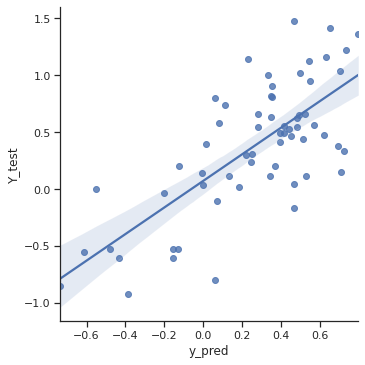

2
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
62
2-fold :  64.51612903225806
3-fold :  79.03225806451613
5-fold :  87.09677419354838
gmfe :  2.067193817697347
mfe :  1.2448467018381393
bias :  -0.044863711715289245
rmse  0.4190837965808567
r2  0.5085937989826884


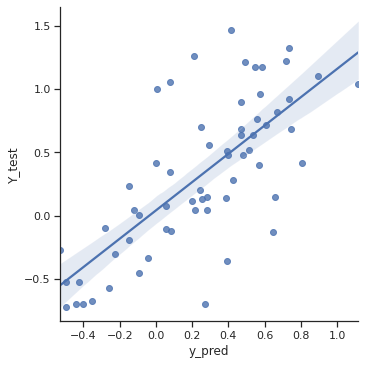

3
(247, 539)
(62, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
62
2-fold :  53.2258064516129
3-fold :  75.80645161290323
5-fold :  90.32258064516128
gmfe :  2.151302788376851
mfe :  1.3065575225564718
bias :  0.2402264308395946
rmse  0.44671570872236843
r2  0.366976634631494


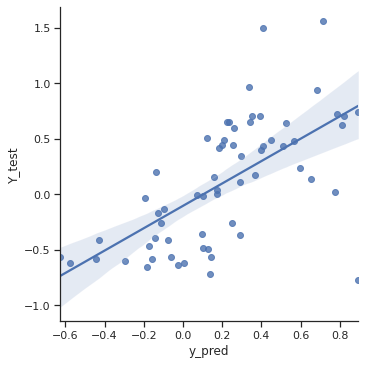

4
(248, 539)
(61, 539)
Running ____________________rat_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)
61
2-fold :  65.57377049180327
3-fold :  85.24590163934425
5-fold :  91.80327868852459
gmfe :  1.8542592466550043
mfe :  1.2048286122235277
bias :  -0.056192208426071144
rmse  0.3913247709237155
r2  0.581048178305255
saving model


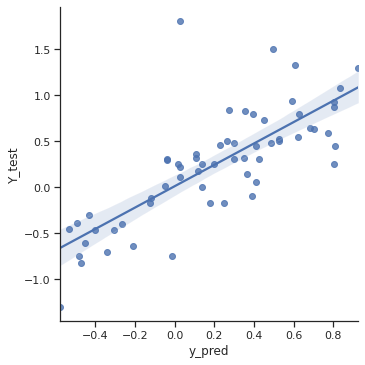

rat_CL_mL_min_kg
0
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=42)
64
2-fold :  57.8125
3-fold :  68.75
5-fold :  79.6875
gmfe :  2.6158053622151245
mfe :  1.2902562032693128
bias :  -3.465842496487695
rmse  0.6454380453764652
r2  0.0032131993744271004
saving model


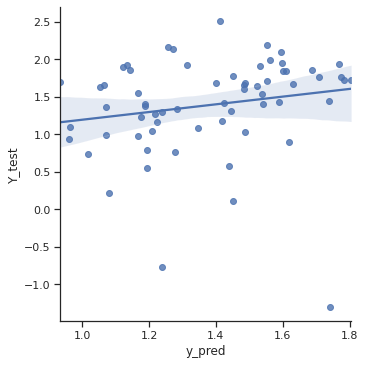

1
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=42)
64
2-fold :  54.6875
3-fold :  68.75
5-fold :  81.25
gmfe :  2.5675258219385055
mfe :  1.2901169269681012
bias :  -2.7960884907018135
rmse  0.5772782990102178
r2  0.1942183358880285
saving model


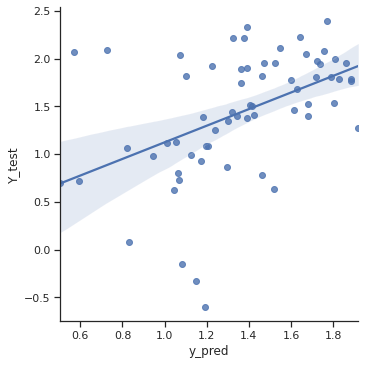

2
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
64
2-fold :  59.375
3-fold :  81.25
5-fold :  85.9375
gmfe :  2.1256884305609605
mfe :  1.3059445116211932
bias :  -2.156776844390782
rmse  0.4305464887706574
r2  0.2938161247081412
saving model


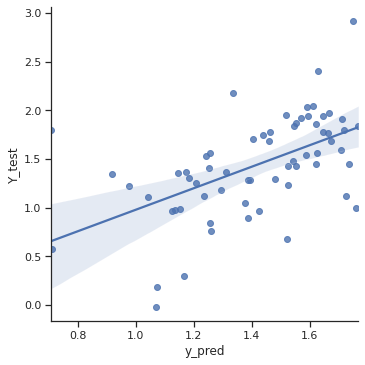

3
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
63
2-fold :  58.730158730158735
3-fold :  74.60317460317461
5-fold :  85.71428571428571
gmfe :  2.476265768259979
mfe :  1.276844709539666
bias :  -5.8824487059182555
rmse  0.5446065078315004
r2  0.21080376710698823


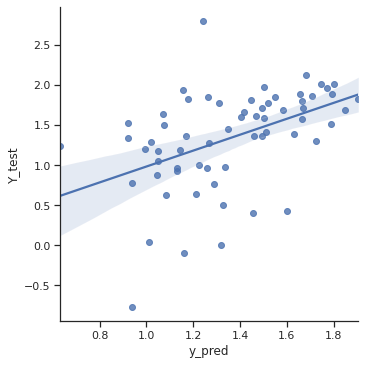

4
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
63
2-fold :  50.79365079365079
3-fold :  69.84126984126983
5-fold :  82.53968253968253
gmfe :  2.6616839404190475
mfe :  1.3500549142093083
bias :  -0.5421874244800549
rmse  0.5865476754880395
r2  0.2354704551907878


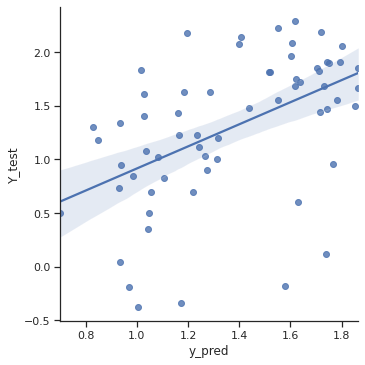

0
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
64
2-fold :  53.125
3-fold :  71.875
5-fold :  82.8125
gmfe :  2.4357472912706415
mfe :  1.3044264525446672
bias :  -1.0914199111271188
rmse  0.5339285174257877
r2  0.29580008053853246


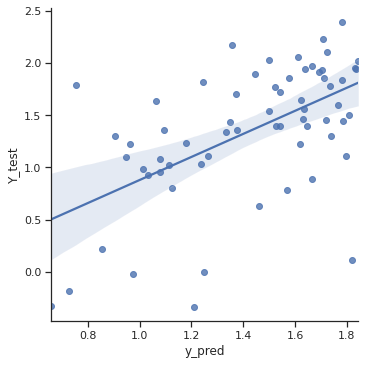

1
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=43)
64
2-fold :  53.125
3-fold :  78.125
5-fold :  84.375
gmfe :  2.308133968631534
mfe :  1.3384743566866615
bias :  -5.593709822828105
rmse  0.5098561370447248
r2  0.15498164382667334


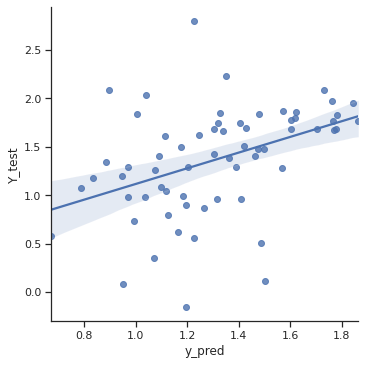

2
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=200,
                      n_jobs=30, random_state=43)
64
2-fold :  59.375
3-fold :  78.125
5-fold :  87.5
gmfe :  2.305903556955914
mfe :  1.254853916051074
bias :  -1.8804578255403284
rmse  0.5617966107144251
r2  0.23352710109473596


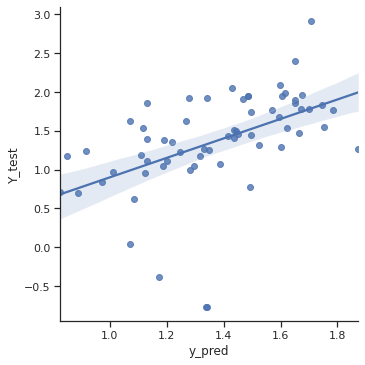

3
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=8,
                      n_estimators=300, n_jobs=30, random_state=43)
63
2-fold :  47.61904761904761
3-fold :  65.07936507936508
5-fold :  80.95238095238095
gmfe :  2.6303149757729307
mfe :  1.4040716480601054
bias :  -5.387129500494602
rmse  0.532951862216104
r2  0.26317585617382966


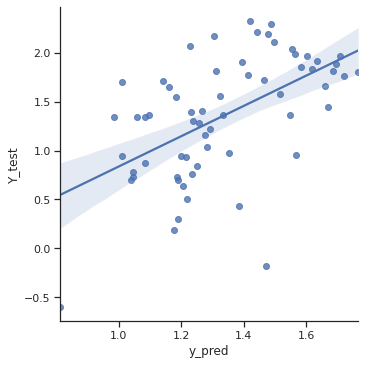

4
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
63
2-fold :  46.03174603174603
3-fold :  65.07936507936508
5-fold :  76.19047619047619
gmfe :  2.9548508215453055
mfe :  1.4098272907371971
bias :  -8.142471243100829
rmse  0.6785943806408014
r2  -0.10224753261144426


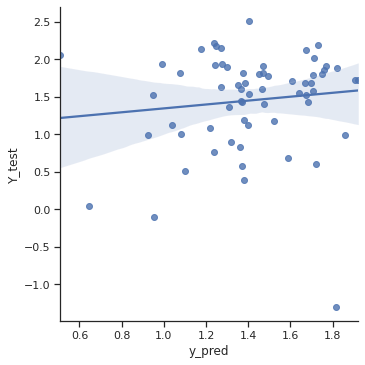

0
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=44)
64
2-fold :  54.6875
3-fold :  71.875
5-fold :  81.25
gmfe :  2.3501422930710807
mfe :  1.2630885489959844
bias :  -0.32243645796862985
rmse  0.51937977237577
r2  0.19901366963547384


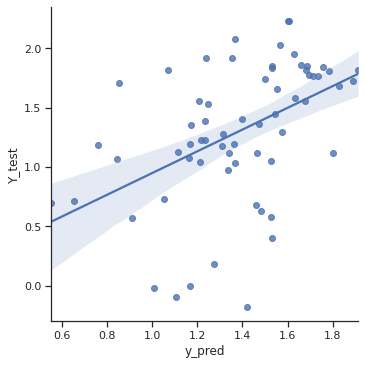

1
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
64
2-fold :  53.125
3-fold :  75.0
5-fold :  85.9375
gmfe :  2.2330429508485556
mfe :  1.2926045839756477
bias :  -1.4750352978866745
rmse  0.47274606764854865
r2  0.2487575951452794


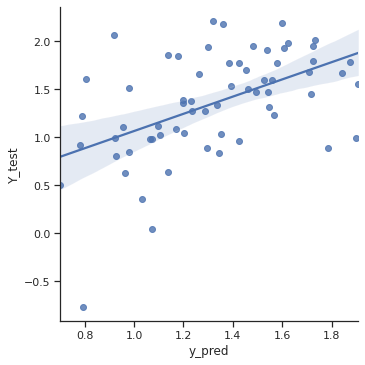

2
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=44)
64
2-fold :  51.5625
3-fold :  68.75
5-fold :  81.25
gmfe :  2.59585924816957
mfe :  1.3500382068680783
bias :  -12.337806998211917
rmse  0.5461781229692378
r2  0.29030894955998354


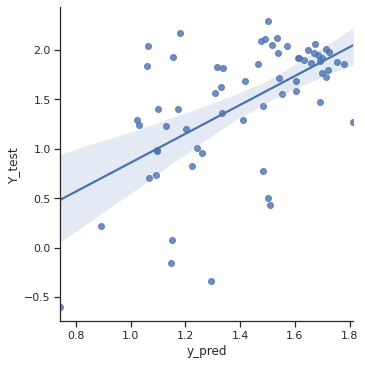

3
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=44)
63
2-fold :  61.904761904761905
3-fold :  76.19047619047619
5-fold :  87.3015873015873
gmfe :  2.29617371243803
mfe :  1.2482627618872593
bias :  -3.09532170637835
rmse  0.5710620789842371
r2  0.16689355828181374


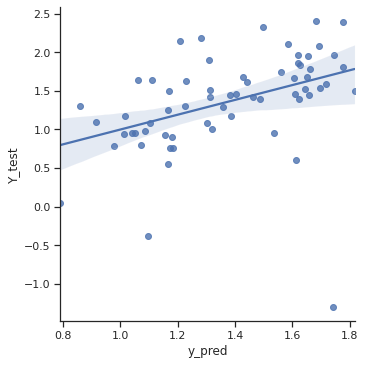

4
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=200,
                      n_jobs=30, random_state=44)
63
2-fold :  46.03174603174603
3-fold :  61.904761904761905
5-fold :  76.19047619047619
gmfe :  2.898655701198421
mfe :  1.3965690010524496
bias :  -7.257938945492384
rmse  0.628239304370764
r2  0.1669208278688945


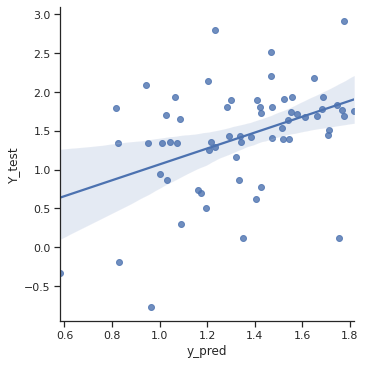

0
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      n_jobs=30, random_state=45)
64
2-fold :  50.0
3-fold :  67.1875
5-fold :  78.125
gmfe :  2.8592521748367847
mfe :  1.358142979782829
bias :  -0.6403431016251506
rmse  0.6160278267828554
r2  0.1395939712602794


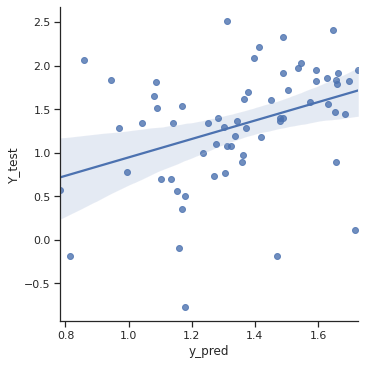

1
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=45)
64
2-fold :  62.5
3-fold :  71.875
5-fold :  79.6875
gmfe :  2.49160038787303
mfe :  1.2701324826984195
bias :  0.9311795096918551
rmse  0.6224165272022273
r2  0.20778665483634484


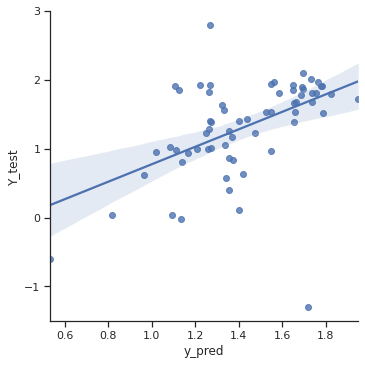

2
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=4,
                      n_jobs=30, random_state=45)
64
2-fold :  46.875
3-fold :  70.3125
5-fold :  79.6875
gmfe :  2.5376139501916226
mfe :  1.3747542375216202
bias :  1.4601505856184467
rmse  0.5501773773592431
r2  0.2311740383948775


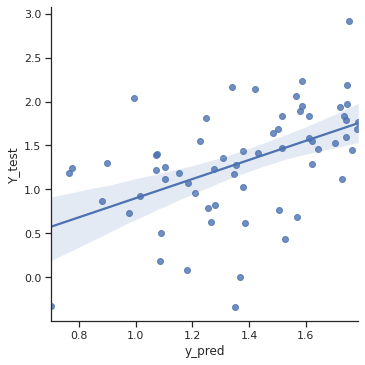

3
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
63
2-fold :  46.03174603174603
3-fold :  61.904761904761905
5-fold :  76.19047619047619
gmfe :  2.788453724522997
mfe :  1.4015742170469776
bias :  -9.682187415684574
rmse  0.5790348111942663
r2  0.08196909782151329


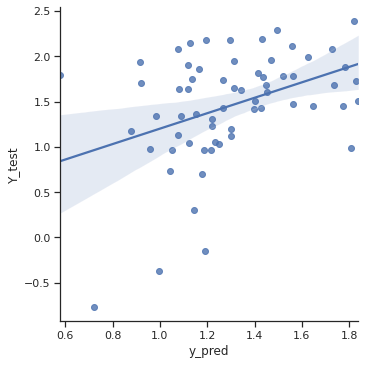

4
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=45)
63
2-fold :  60.317460317460316
3-fold :  77.77777777777779
5-fold :  90.47619047619048
gmfe :  2.0049636268113566
mfe :  1.2185722298111394
bias :  -6.004606298065742
rmse  0.40771557650047036
r2  0.18761601145886997
saving model


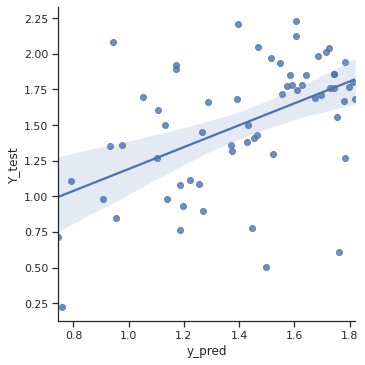

0
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=46)
64
2-fold :  57.8125
3-fold :  76.5625
5-fold :  84.375
gmfe :  2.500123742485027
mfe :  1.2624646936103476
bias :  2.0778703227606314
rmse  0.581618158982434
r2  0.22350571761269666


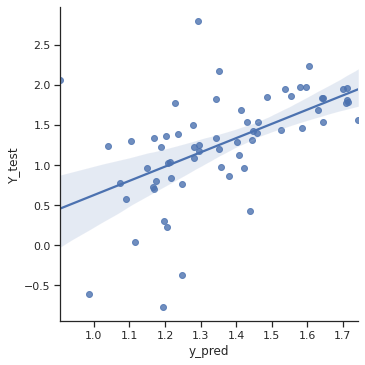

1
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=46)
64
2-fold :  62.5
3-fold :  81.25
5-fold :  89.0625
gmfe :  2.1507206961598095
mfe :  1.2584524298583486
bias :  -5.795009273928812
rmse  0.5417898495012172
r2  0.23453511913537262


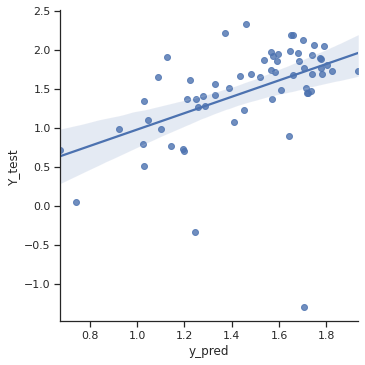

2
(254, 539)
(64, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_jobs=30, random_state=46)
64
2-fold :  46.875
3-fold :  60.9375
5-fold :  78.125
gmfe :  2.611202288964483
mfe :  1.3842748421126
bias :  -6.5801407186881615
rmse  0.548070663258086
r2  0.24521209848140724


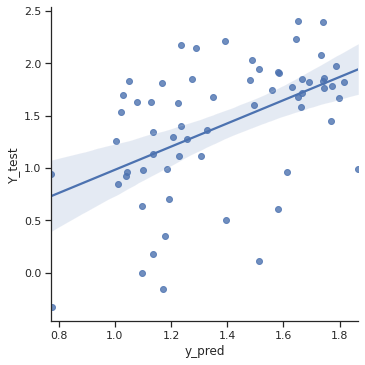

3
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=46)
63
2-fold :  49.2063492063492
3-fold :  60.317460317460316
5-fold :  73.01587301587301
gmfe :  2.9617994695898733
mfe :  1.3747010604213756
bias :  -4.299768319504885
rmse  0.6279534961536843
r2  0.002141858259557039


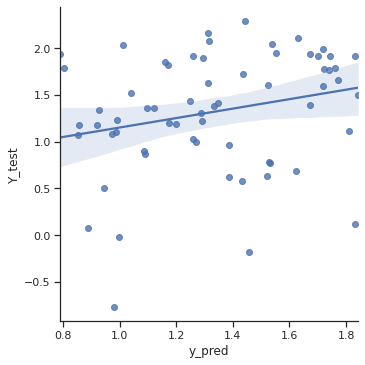

4
(255, 539)
(63, 539)
Running ____________________rat_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=46)
63
2-fold :  57.14285714285714
3-fold :  76.19047619047619
5-fold :  88.88888888888889
gmfe :  2.1738539337884437
mfe :  1.2975033326586638
bias :  -4.540217080784142
rmse  0.4429577689429899
r2  0.33412195883044316


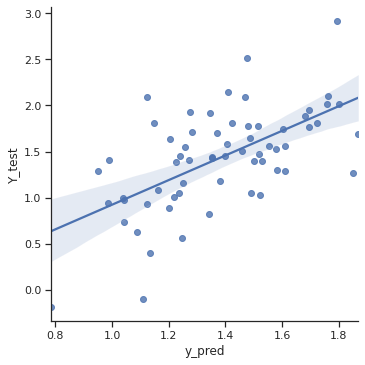

rat_fup
0
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
43
2-fold :  53.48837209302325
3-fold :  69.76744186046511
5-fold :  81.3953488372093
gmfe :  2.713243045258027
mfe :  1.3427746267746834
bias :  0.06932855249554362
rmse  0.2700471690825098
r2  0.27166407689818095
saving model


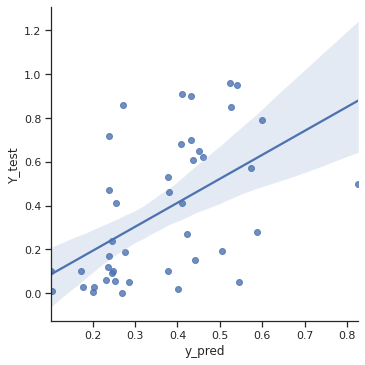

1
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
43
2-fold :  69.76744186046511
3-fold :  76.74418604651163
5-fold :  81.3953488372093
gmfe :  2.0895466486326555
mfe :  1.1574662915786207
bias :  -0.0368198881443956
rmse  0.23170455283094968
r2  0.43579351928806265
saving model


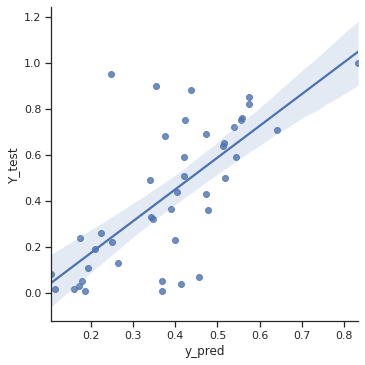

2
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
43
2-fold :  67.44186046511628
3-fold :  81.3953488372093
5-fold :  86.04651162790698
gmfe :  2.22533477865245
mfe :  1.249273614538474
bias :  -0.04008194444444496
rmse  0.2696639590354674
r2  0.41941459690778005


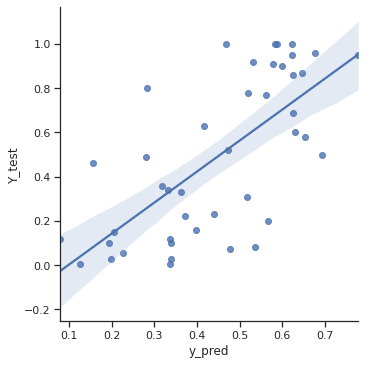

3
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=42)
43
2-fold :  51.162790697674424
3-fold :  65.11627906976744
5-fold :  69.76744186046511
gmfe :  3.445147153833787
mfe :  1.3181863466745554
bias :  0.11840958333333329
rmse  0.23732614888568404
r2  0.21507921118394524


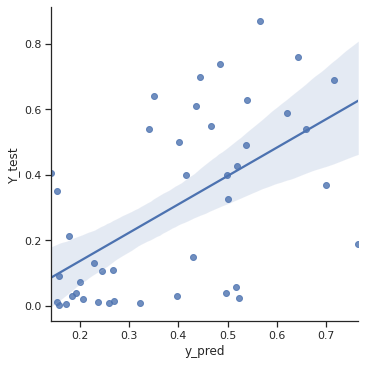

4
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=42)
43
2-fold :  46.51162790697674
3-fold :  62.7906976744186
5-fold :  76.74418604651163
gmfe :  3.269319685605085
mfe :  1.422236101534421
bias :  0.09179550489127747
rmse  0.28679752428907684
r2  0.3488534810759696


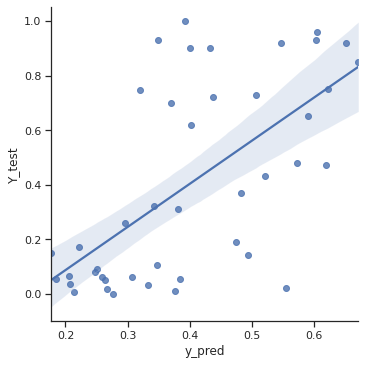

0
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
43
2-fold :  60.46511627906976
3-fold :  74.4186046511628
5-fold :  81.3953488372093
gmfe :  2.36707982594506
mfe :  1.2476661470954429
bias :  0.05635141666666654
rmse  0.23707070149516174
r2  0.4054425725399746


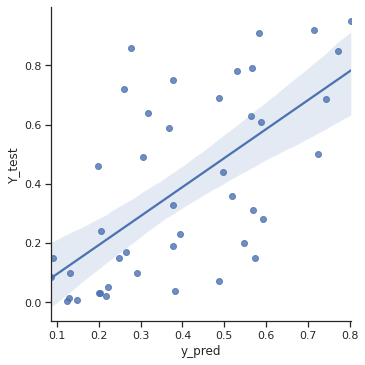

1
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
43
2-fold :  53.48837209302325
3-fold :  67.44186046511628
5-fold :  79.06976744186046
gmfe :  2.588811681897998
mfe :  1.3201346767169992
bias :  0.018735183838383573
rmse  0.2484465432436846
r2  0.4129314530020478


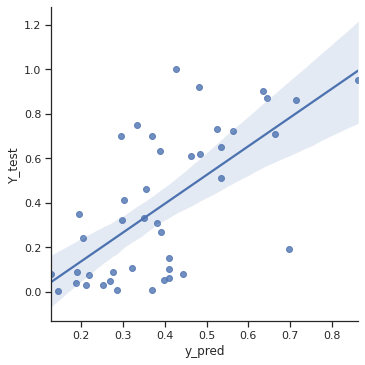

2
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
43
2-fold :  58.139534883720934
3-fold :  72.09302325581395
5-fold :  76.74418604651163
gmfe :  2.780073663757798
mfe :  1.2984388361626915
bias :  -0.005204999999999849
rmse  0.29380803534844796
r2  0.375119587685101


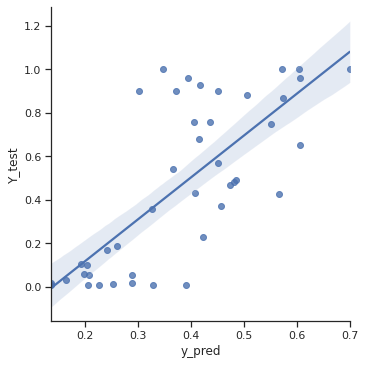

3
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
43
2-fold :  55.81395348837209
3-fold :  65.11627906976744
5-fold :  74.4186046511628
gmfe :  3.2186335836976263
mfe :  1.2709823139967091
bias :  0.09661400000000014
rmse  0.25919797313360027
r2  0.20980201415374256


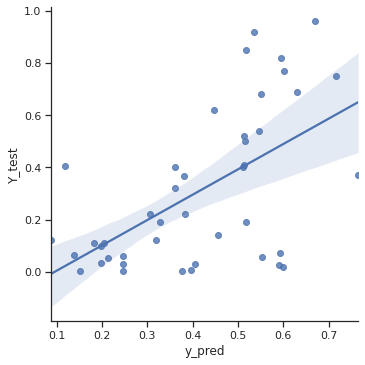

4
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
43
2-fold :  65.11627906976744
3-fold :  76.74418604651163
5-fold :  83.72093023255815
gmfe :  2.4930525865096484
mfe :  1.212046164283748
bias :  0.005436166666667019
rmse  0.25900144675040576
r2  0.33579893562641383


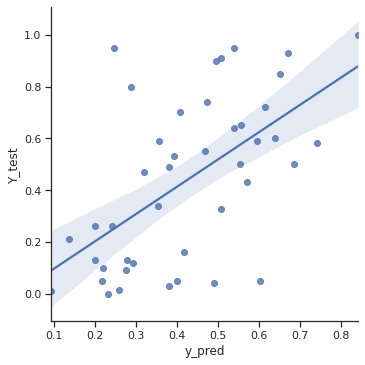

0
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=44)
43
2-fold :  62.7906976744186
3-fold :  67.44186046511628
5-fold :  83.72093023255815
gmfe :  2.4177870073712606
mfe :  1.2074274972853245
bias :  0.060132341235334924
rmse  0.2645540842488414
r2  0.2375094396445655


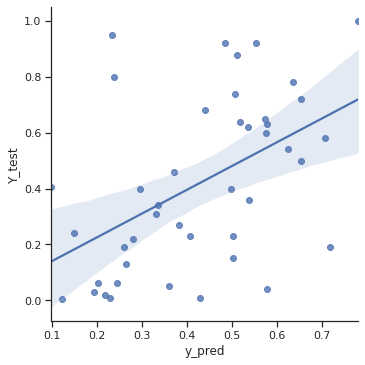

1
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
43
2-fold :  58.139534883720934
3-fold :  67.44186046511628
5-fold :  81.3953488372093
gmfe :  2.9705599959659437
mfe :  1.264662777924918
bias :  0.07790897958953638
rmse  0.2402651836945218
r2  0.5048398339608641


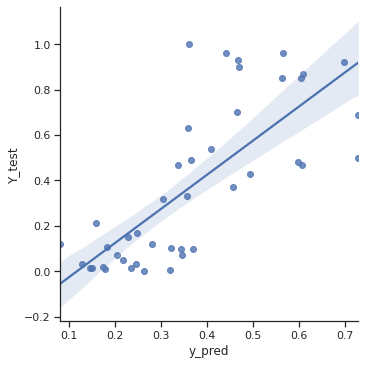

2
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=44)
43
2-fold :  58.139534883720934
3-fold :  74.4186046511628
5-fold :  79.06976744186046
gmfe :  2.6157093028385323
mfe :  1.3084379365649306
bias :  0.012600360018071688
rmse  0.2731000757089558
r2  0.38985917544171633


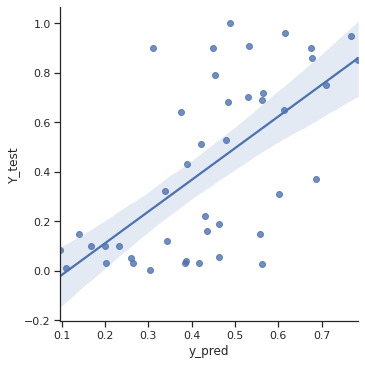

3
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
43
2-fold :  67.44186046511628
3-fold :  74.4186046511628
5-fold :  83.72093023255815
gmfe :  2.325976034377929
mfe :  1.210471822252643
bias :  -0.03670324999999991
rmse  0.24751393455967938
r2  0.44536909131804414


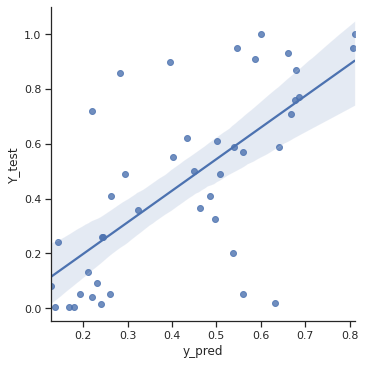

4
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
43
2-fold :  48.837209302325576
3-fold :  65.11627906976744
5-fold :  79.06976744186046
gmfe :  2.8195859513172605
mfe :  1.4097327618545614
bias :  0.08993538095238093
rmse  0.22359907636179724
r2  0.424971465634301


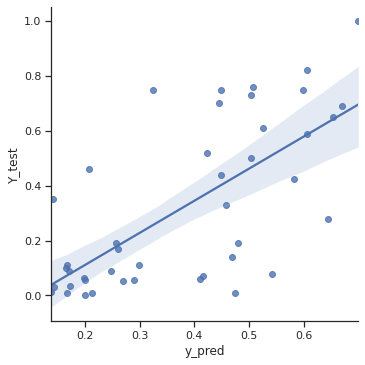

0
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
43
2-fold :  67.44186046511628
3-fold :  79.06976744186046
5-fold :  90.69767441860465
gmfe :  1.9179605966620688
mfe :  1.1988829327476067
bias :  0.033967711904761805
rmse  0.19304731610576595
r2  0.43093897949783444
saving model


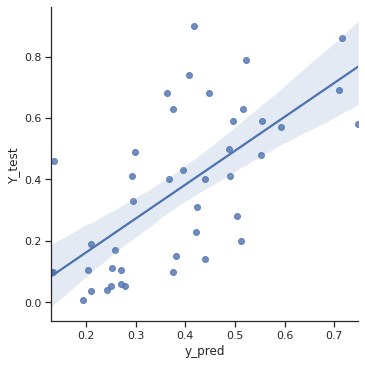

1
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
43
2-fold :  69.76744186046511
3-fold :  76.74418604651163
5-fold :  86.04651162790698
gmfe :  2.0569689746498607
mfe :  1.2094729949916747
bias :  -0.011607554551806648
rmse  0.25260116203024985
r2  0.38067786200919485


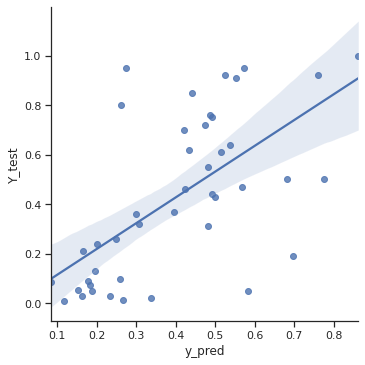

2
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
43
2-fold :  62.7906976744186
3-fold :  67.44186046511628
5-fold :  72.09302325581395
gmfe :  3.277437268049706
mfe :  1.2898718065484711
bias :  0.012225451449939029
rmse  0.2675569192129248
r2  0.5105248150004545


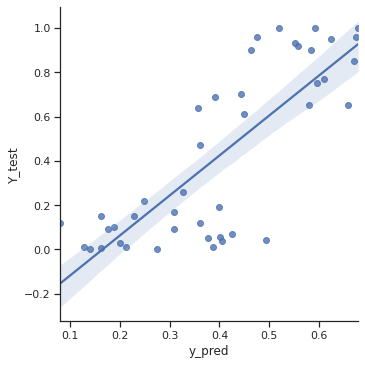

3
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
43
2-fold :  53.48837209302325
3-fold :  65.11627906976744
5-fold :  76.74418604651163
gmfe :  2.7458664887232964
mfe :  1.3363770286993224
bias :  -0.04685726825396874
rmse  0.29718306928799854
r2  0.2804137103198916


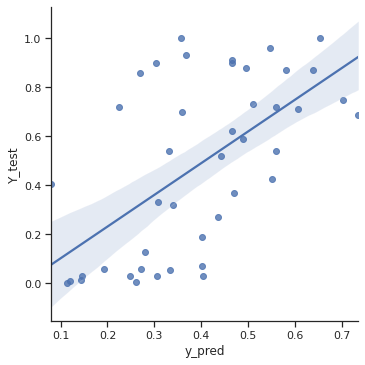

4
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
43
2-fold :  48.837209302325576
3-fold :  60.46511627906976
5-fold :  72.09302325581395
gmfe :  3.6015760471329097
mfe :  1.3550679059200912
bias :  0.11746045085470073
rmse  0.2615169839567563
r2  0.14008726637404068


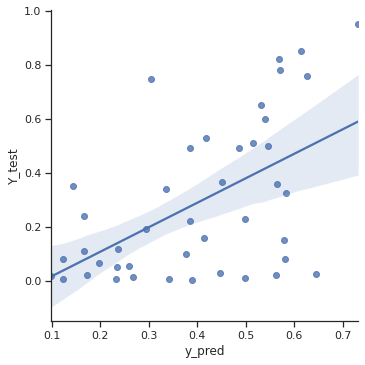

0
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
43
2-fold :  55.81395348837209
3-fold :  67.44186046511628
5-fold :  69.76744186046511
gmfe :  3.3185648957213623
mfe :  1.2630742858799728
bias :  0.04605594211711715
rmse  0.2724315651401359
r2  0.39306346579405205


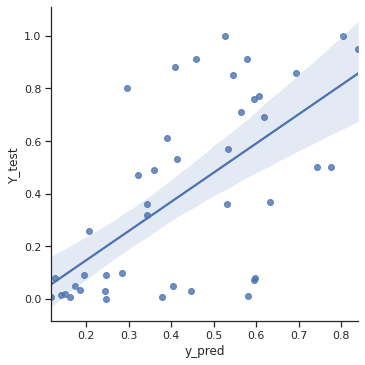

1
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
43
2-fold :  55.81395348837209
3-fold :  67.44186046511628
5-fold :  74.4186046511628
gmfe :  2.6128459193918716
mfe :  1.2443256975320456
bias :  0.05521258202975826
rmse  0.263264425048571
r2  0.19923279278082218


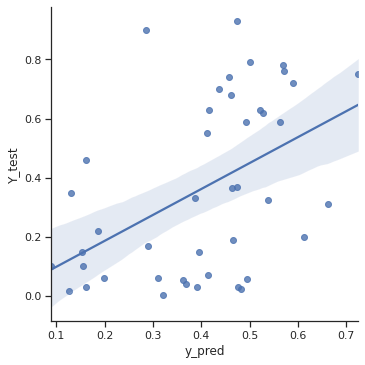

2
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
43
2-fold :  58.139534883720934
3-fold :  72.09302325581395
5-fold :  86.04651162790698
gmfe :  2.556384510717989
mfe :  1.2420844189277074
bias :  0.03484267041348829
rmse  0.2508867285181409
r2  0.43034386504554545


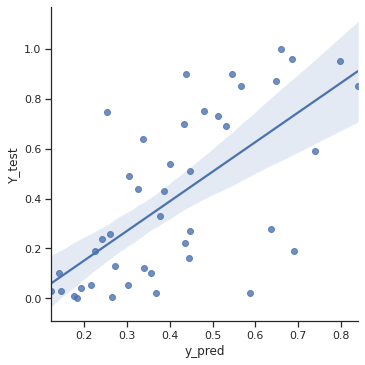

3
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
43
2-fold :  51.162790697674424
3-fold :  72.09302325581395
5-fold :  86.04651162790698
gmfe :  2.5466457732443644
mfe :  1.3508566446347634
bias :  0.09566320050875046
rmse  0.2388806131472394
r2  0.3476434414079581


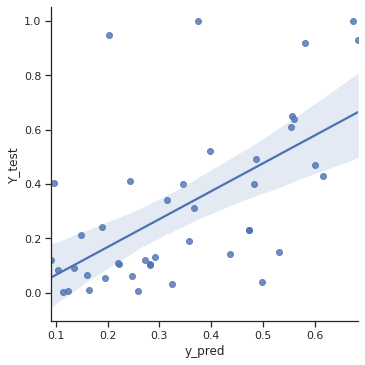

4
(172, 539)
(43, 539)
Running ____________________rat_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
43
2-fold :  65.11627906976744
3-fold :  79.06976744186046
5-fold :  81.3953488372093
gmfe :  2.3296896435740377
mfe :  1.1884634327111403
bias :  -0.054726611111110324
rmse  0.2664770204983857
r2  0.360395259838326


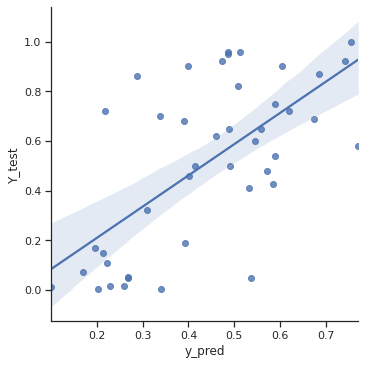

In [17]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]

for endpoint in ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]:
    
    baseline=10.00
    #log human_VDss_L_kg model
    data = rat_mfp_Mordred
    features = features_mfp_mordred_columns
        

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
         
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    for i in range(42,47):
        

        #Nested Cross Validation    
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            print(split)

            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            #if (r2>baseline):
            if (gmfe<baseline):    
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)


In [18]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

,HeldOut,endpoint,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
0,HeldOut,rat_VDss_L_kg,42,0,58.064516,69.354839,90.322581,2.123129,1.222044,-0.046464,0.429505,0.481343
1,HeldOut,rat_VDss_L_kg,42,1,59.677419,83.870968,90.322581,1.980003,1.237064,0.000293,0.411846,0.502609
2,HeldOut,rat_VDss_L_kg,42,2,56.451613,74.193548,98.387097,2.023366,1.303814,0.207663,0.367671,0.537939
3,HeldOut,rat_VDss_L_kg,42,3,51.612903,74.193548,88.709677,2.305667,1.312386,0.012048,0.489024,0.410619
4,HeldOut,rat_VDss_L_kg,42,4,55.737705,78.688525,88.524590,2.173394,1.320804,-0.108650,0.440999,0.498638
...,...,...,...,...,...,...,...,...,...,...,...,...
70,HeldOut,rat_fup,46,0,55.813953,67.441860,69.767442,3.318565,1.263074,0.046056,0.272432,0.393063
71,HeldOut,rat_fup,46,1,55.813953,67.441860,74.418605,2.612846,1.244326,0.055213,0.263264,0.199233
72,HeldOut,rat_fup,46,2,58.139535,72.093023,86.046512,2.556385,1.242084,0.034843,0.250887,0.430344
73,HeldOut,rat_fup,46,3,51.162791,72.093023,86.046512,2.546646,1.350857,0.095663,0.238881,0.347643


In [19]:
results.to_csv("Prediction_rat_from_mordred_morgan_fs.csv", index=False)

In [20]:
import pandas as pd
results= pd.read_csv("Prediction_rat_from_mordred_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("rat.csv", index=False)
results.groupby("endpoint").mean()

,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
endpoint,,,,,,,,,,
rat_CL_mL_min_kg,44.0,2.0,53.889881,71.180556,82.260913,2.501415,1.319040,-3.780006,0.554276,0.189692
rat_VDss_L_kg,44.0,2.0,56.637758,75.471179,89.899524,2.139232,1.291965,0.001946,0.436267,0.456912
rat_fup,44.0,2.0,58.604651,70.697674,79.720930,2.692152,1.276737,0.034427,0.256238,0.356231


In [21]:
# load
loaded_rf = pickle.load(open("log_rat_VDss_L_kg_model.sav", 'rb'))

In [22]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)

In [23]:
import pickle
list_of_lists=[]


for endpoint in ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]:
    
    baseline=10.00
    #log human_VDss_L_kg model
    data = rat_mfp_Mordred
    features = features_mfp_mordred_columns
        

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    # Save the scaler to a file
    with open('scaler_rat.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    
    X_train= X.values
    Y_train= Y.values.flatten()

    print(X_train.shape)
    print(X_test.shape)

          
    loaded_rf = pickle.load(open(f"log_{endpoint}_model.sav", 'rb'))

    
    params = loaded_rf.get_params()
    
    classifier= RandomForestRegressor(**params)
    classifier.fit(X_train, Y_train)
    
    pickle.dump(classifier, open(f"log_{endpoint}_model_FINAL.sav", 'wb'))

rat_VDss_L_kg
(309, 539)
(43, 539)
rat_CL_mL_min_kg
(318, 539)
(43, 539)
rat_fup
(215, 539)
(43, 539)
